# Import Data

In [1]:
import pandas as pd

train_df = pd.read_csv('../../input/feedback-prize-effectiveness/train.csv')
stack_df = pd.read_csv('../../29_Pseudo4/exp/result/29_vl_01/oof_df.csv')
stack_df = stack_df.rename(columns={'pred_ineffective':'Ineffective','pred_adequate':'Adequate','pred_effective':'Effective'})
num_models = 1 

train_df = train_df[['discourse_id']].merge(stack_df, on='discourse_id', how='left')
print(train_df.shape)
train_df.head()

(36765, 11)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,Ineffective,Adequate,Effective,label,loss,prob_seq
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,0.019449,0.965471,0.015080,1,0.035139,[[0.31425968 0.66088176 0.0248585 ]\n [0.16091...
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,0.096693,0.885061,0.018245,1,0.122098,[[0.20109865 0.77783215 0.02106918]\n [0.26757...
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,0.444879,0.548619,0.006502,1,0.600352,[[3.0868194e-01 6.7630327e-01 1.5014793e-02]\n...
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,0.353133,0.639997,0.006870,1,0.446291,[[4.50068086e-01 5.35973966e-01 1.39579177e-02...
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,0.353207,0.639092,0.007701,1,0.447708,[[0.5043826 0.47832486 0.01729247]\n [0.61064...


In [2]:
# https://stackoverflow.com/questions/45704999/how-to-convert-vector-wrapped-as-string-to-numpy-array-in-pandas-dataframe
import numpy as np
train_df['prob_seq'] = train_df['prob_seq'].apply(lambda x:np.fromstring(
                                x.replace('\n','')
                                 .replace('[','')
                                 .replace(']','')
                                 .replace('  ',' '), sep=' '))
prob_seqs = [train_df['prob_seq'].values[i].reshape(-1,3) for i in range(len(train_df))]

/home/takesako/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  import sys


# Features

In [3]:
from shujun_features import get_xgb_features

train_df = get_xgb_features(train_df, prob_sequences=prob_seqs, use_prob_seq=True)
print('train_df.shape = ', train_df.shape)
train_df.head(2)

36765it [00:01, 21187.55it/s]
 12%|█▏        | 4512/36765 [00:00<00:00, 45118.32it/s]

calculated_features.shape =  (36765, 10)


100%|██████████| 36765/36765 [00:00<00:00, 44121.17it/s]


train_df.shape =  (36765, 44)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,Ineffective,Adequate,Effective,label,loss,...,std_Adequate,std_Effective,discourse_count,Claim_count,Evidence_count,Concluding Statement_count,Lead_count,Position_count,Counterclaim_count,Rebuttal_count
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,0.019449,0.965471,0.015080,1,0.035139,...,0.238197,0.005179,9,1,2,1,1,1,2,1
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,0.096693,0.885061,0.018245,1,0.122098,...,0.238197,0.005179,9,1,2,1,1,1,2,1


In [4]:
train_df.columns

Index(['discourse_id', 'essay_id', 'discourse_text', 'discourse_type',
       'discourse_effectiveness', 'Ineffective', 'Adequate', 'Effective',
       'label', 'loss', 'prob_seq', 'instability_0', 'instability_1',
       'instability_2', 'instability_3', 'begin_0', 'begin_1', 'begin_2',
       'end_0', 'end_1', 'end_2', 'len', 'Ineffective_previous',
       'Adequate_previous', 'Effective_previous', 'discourse_type_previous',
       'Ineffective_next', 'Adequate_next', 'Effective_next',
       'discourse_type_next', 'mean_Ineffective', 'mean_Adequate',
       'mean_Effective', 'std_Ineffective', 'std_Adequate', 'std_Effective',
       'discourse_count', 'Claim_count', 'Evidence_count',
       'Concluding Statement_count', 'Lead_count', 'Position_count',
       'Counterclaim_count', 'Rebuttal_count'],
      dtype='object')

In [5]:
seq_cols = [f"instability_{i}" for i in range(4)] + [f"begin_{i}" for i in range(3)] + [f"end_{i}" for i in range(3)] + ['len']

In [6]:
cols = ['discourse_type','discourse_type_previous','discourse_type_next']
cols += ['Ineffective','Adequate','Effective']

cols += [
    'Ineffective_previous', 'Adequate_previous', 'Effective_previous', 
    'Ineffective_next', 'Adequate_next', 'Effective_next',
    'mean_Ineffective', 'mean_Adequate', 'mean_Effective',
    'std_Ineffective', 'std_Adequate', 'std_Effective', 
    'discourse_count', 'Claim_count', 'Evidence_count', 'Concluding Statement_count',
    'Lead_count', 'Position_count', 'Counterclaim_count', 'Rebuttal_count'
]

cols += seq_cols

In [7]:
len(cols)

37

# Data Split

In [8]:
from os.path import join as opj

class args:
    fold_path = '../../00_EDA/00_v2_07/result/'
    num_fold = 5
    
fold_path = args.fold_path
import joblib
print('load folds...')
trn_ids_list = joblib.load(opj(fold_path,f'trn_ids_list.joblib'))
val_ids_list = joblib.load(opj(fold_path,f'val_ids_list.joblib'))

load folds...


# Stacking

In [9]:
import matplotlib.pyplot as plt

def show_feature_importance(model):
    feature_importance = model.get_feature_importance()
    fi_df = pd.DataFrame({'importance':feature_importance, 'features':cols})
    fi_df = fi_df.sort_values('importance', ascending=True)

    plt.figure(figsize=(12, 6))
    plt.barh(range(len(fi_df)),
            fi_df['importance'].values,
            tick_label=fi_df['features'].values)
    plt.xlabel('importance')
    plt.ylabel('features')
    plt.grid()
    plt.show()

In [10]:
import catboost
params = {
    'random_state':45, 
    'n_estimators':20000,
    'loss_function':'MultiClass',
}

fold0 : CV=0.5758


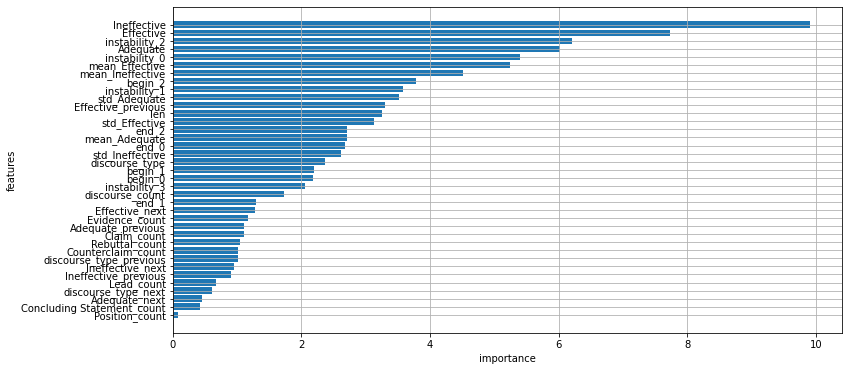

fold1 : CV=0.5945


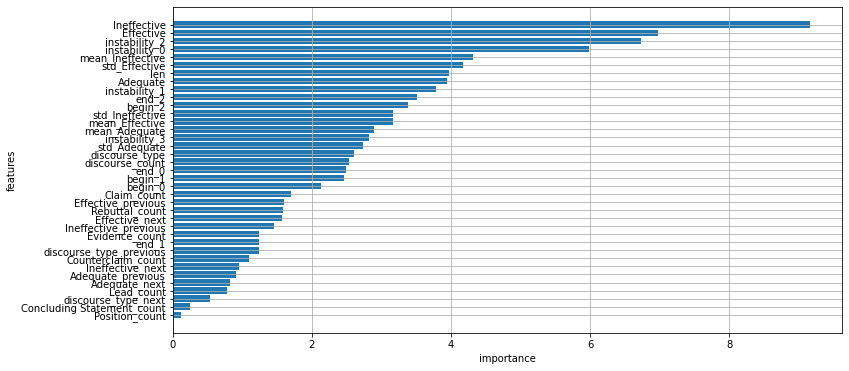

fold2 : CV=0.5743


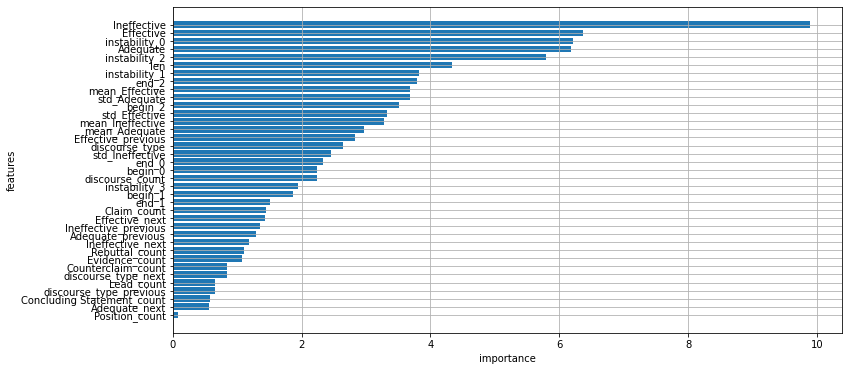

fold3 : CV=0.5925


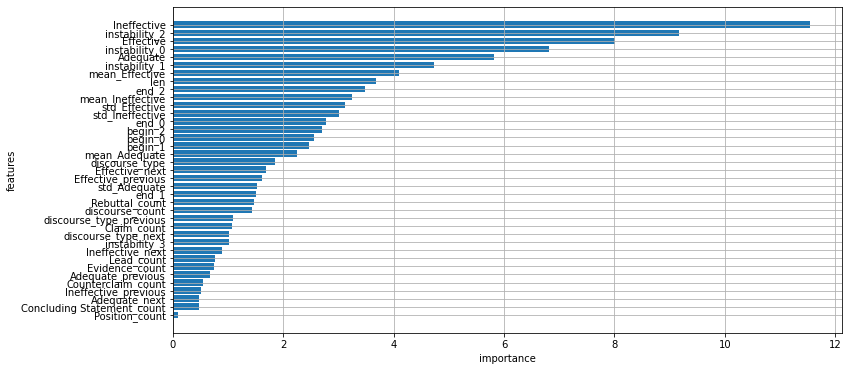

fold4 : CV=0.5825


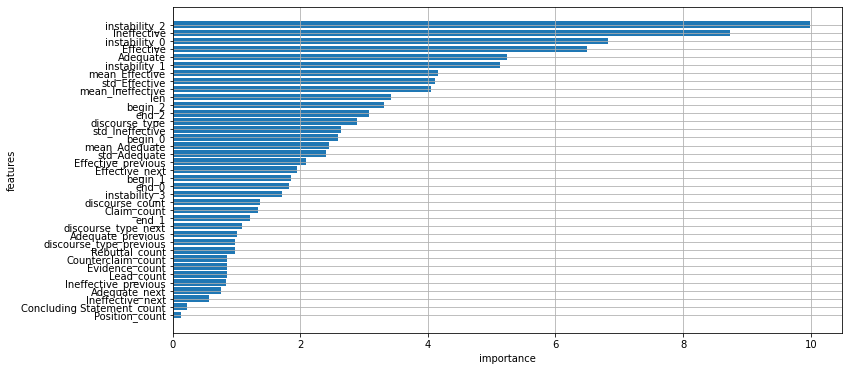

CV=0.5839


In [11]:
from sklearn.metrics import log_loss
import pickle
import os
os.makedirs('./result', exist_ok=True)

cat_features = [0,1,2]

score_list = []
oof_df = []
for fold in range(args.num_fold):
    trn_df = train_df[train_df['essay_id'].isin(trn_ids_list[fold])].reset_index(drop=True)
    val_df = train_df[train_df['essay_id'].isin(val_ids_list[fold])].reset_index(drop=True)

    pool_trn = catboost.Pool(trn_df[cols].values, label=trn_df['label'].values, cat_features=cat_features)
    pool_val = catboost.Pool(val_df[cols].values, label=val_df['label'].values, cat_features=cat_features)

    model = catboost.CatBoostClassifier(**params)
    model.fit(pool_trn, 
              eval_set=[pool_val], 
              verbose=0, 
              early_stopping_rounds=100,
             )

    pred = model.predict(pool_val, prediction_type='Probability')
    target = val_df['label'].values
    score = log_loss(target, pred, labels=[0,1,2])
    print('fold{} : CV={:.4f}'.format(fold, score))
    score_list.append(score)
    val_df['oof_ineffective'] = pred[:,0]
    val_df['oof_adequate'] = pred[:,1]
    val_df['oof_effective'] = pred[:,2]
    oof_df.append(val_df)
    # save model
    joblib.dump(model, f'./result/cat_fold{fold}.joblib')
    # plot
    show_feature_importance(model)
    
CV = sum(score_list) / len(score_list)
print('CV={:.4f}'.format(CV))

In [12]:
oof_df = pd.concat(oof_df).reset_index(drop=True)
oof_df = train_df[['discourse_id']].merge(oof_df, on='discourse_id', how='left')
oof_df.to_csv(f'./result/oof_cat.csv', index=False)
print(oof_df.shape)
oof_df.head()

(36765, 47)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,Ineffective,Adequate,Effective,label,loss,...,Claim_count,Evidence_count,Concluding Statement_count,Lead_count,Position_count,Counterclaim_count,Rebuttal_count,oof_ineffective,oof_adequate,oof_effective
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,0.019449,0.965471,0.015080,1,0.035139,...,1,2,1,1,1,2,1,0.027419,0.933093,0.039488
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,0.096693,0.885061,0.018245,1,0.122098,...,1,2,1,1,1,2,1,0.088593,0.874338,0.037069
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,0.444879,0.548619,0.006502,1,0.600352,...,1,2,1,1,1,2,1,0.388401,0.602788,0.008810
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,0.353133,0.639997,0.006870,1,0.446291,...,1,2,1,1,1,2,1,0.367315,0.623947,0.008737
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,0.353207,0.639092,0.007701,1,0.447708,...,1,2,1,1,1,2,1,0.314738,0.678034,0.007228


In [13]:
cols = [col for col in oof_df.columns if col.startswith('oof_')]

oof_score = log_loss(oof_df['label'].values, oof_df[cols].values, labels=[0,1,2])
print('oof={:.4f}'.format(oof_score))

oof=0.5840
